# TP4 INFO8003
The idea behind this notebook is to get familiar with the K-bandits problem and advanced Q-learning with deep Q network (DQN).

## Part 1: K-bandits problem

### Desciption of the problem

In this first part, we will study the K-armed bandit problem provided here below

In [1]:
## DO NOT CHANGE
import numpy as np
import matplotlib.pyplot as plt

class KArmedBandit:
    def __init__(self, number_of_arms, true_rewards, width):
        self.number_of_arms = number_of_arms
        assert len(true_rewards) == number_of_arms
        self.true_rewards = true_rewards
        assert len(width) == number_of_arms
        self.width = width
        self.arm_counts = np.zeros(number_of_arms)
        self.cumulative_reward = 0

    def pull_arm(self, k):
        reward = np.random.uniform(self.true_rewards[k]- self.width[k]/2, self.true_rewards[k] + self.width[k]/2)
        self.arm_counts[k] += 1
        self.cumulative_reward += reward
        return reward

    def get_cummulative_reward(self):
        return self.cumulative_reward

    def reset(self):
        self.cumulative_reward = 0
        self.arm_counts = np.zeros(number_of_arms)

# Parameters
number_of_arms = 4
true_rewards = np.linspace(0.4, 0.46, number_of_arms)
width = np.array([0.2] * number_of_arms)

bandit = KArmedBandit(number_of_arms, true_rewards, width)

You can try a random strategy to pull arms and observe the behavior by running the following code:

In [2]:
num_steps = 1000

for i in range(num_steps):
    reward = bandit.pull_arm(np.random.choice(number_of_arms))
print(f"Rewards collected: {bandit.cumulative_reward}")

Rewards collected: 428.71019729160383


Another exploration strategy seen in the course is the epsilon-greedy. Try the following code to run this strategy:

In [3]:
# DO NOT CHANGE
class EpsilonGreedy:
    def __init__(self, number_of_arms, epsilon):
        self.number_of_arms = number_of_arms
        self.epsilon = epsilon
        self.arm_values = np.zeros(number_of_arms)
        self.arm_counts = np.zeros(number_of_arms)

    def choose_arm(self):
        for k, arm_count in enumerate(self.arm_counts):
            if arm_count == 0:
                return k
        return np.random.choice([np.argmax(self.arm_values), np.random.choice(number_of_arms)], p=[1-self.epsilon, self.epsilon])

    def update(self, reward, arm_selected):
        self.epsilon *= 0.99
        self.arm_counts[arm_selected] += 1
        self.arm_values[arm_selected] = (1 - 1 / self.arm_counts[arm_selected]) * self.arm_values[arm_selected] + 1 / self.arm_counts[arm_selected] * reward

    def reset(self):
        self.arm_values = np.zeros(number_of_arms)

    def get_arm_counts(self):
        return self.arm_counts.copy()

# Parameters
number_of_arms = 4
true_rewards = np.linspace(0.4, 0.46, number_of_arms)
width = np.array([0.2] * number_of_arms)

# Run experiment
bandit = KArmedBandit(number_of_arms, true_rewards, width)
epsilon = 0.1
eps = EpsilonGreedy(number_of_arms, epsilon)
num_steps = 1000
arm_counts_history = []

for i in range(num_steps):
    j = eps.choose_arm()
    reward = bandit.pull_arm(j)
    eps.update(reward, j)
    current_result = eps.get_arm_counts()
    arm_counts_history.append(current_result)
print(f"Arm counters: {eps.get_arm_counts()}")
print(f"Arm values: {eps.arm_values}")
print(f"Rewards collected: {bandit.cumulative_reward}")

Arm counters: [  6.   4.   4. 986.]
Arm values: [0.39142527 0.38769951 0.4536778  0.45759272]
Rewards collected: 456.90048058586103


### Question 1

During the course, we have seen an algorithm called Upper Confidence Bound (UCB) Algorithm. Code the UCB algorithm following the same API than the EpsilonGreedy class to solve the following K-armed bandit problem. The pseudo code here below is given to help you.


### Upper Confidence Bound (UCB) Algorithm Pseudo Code

#### Input:
- `K`: Number of arms (actions)
- `N`: Total number of rounds (iterations)

##### Initialize:
- `counts[k]` = 0 for all `k` in `[1, K]` (number of times arm `k` has been selected)
- `values[k]` = 0 for all `k` in `[1, K]` (sum of rewards obtained from arm `k`)

##### For `t` = 1 to `N` do:
  1. For each arm `k` in `[1, K]` do:
     - If `counts[k]` > 0 then:
       - `mean_reward[k]` = `values[k]` / `counts[k]`
     - Else:
       - `mean_reward[k]` = 0

  2. For each arm `k` in `[1, K]` do:
     - `ucb_value[k]` = `mean_reward[k]` + sqrt((1.5 * log(n)) / `counts[k]`)

  3. Select arm `j` with the highest `ucb_value[j]`

  4. Pull arm `j` and observe reward `r`

  5. Update `counts[j]` = `counts[j]` + 1

  6. Update `values[j]` = `values[j]` + `r`

#### Output:
- `counts` the number of times each arm has been selected


In [4]:
class Ucb:
    def __init__(self, number_of_arms):
        self.number_of_arms = number_of_arms
        self.arm_counts = np.zeros(number_of_arms)
        self.arm_values = np.zeros(number_of_arms)
        self.ucb_values = np.zeros(number_of_arms) + np.inf
        self.n = 1

    def choose_arm(self):
        # For arms that haven't been chosen yet, return them first
        for k, arm_count in enumerate(self.arm_counts):
            if arm_count == 0:
                return k

        # Calculate UCB values for all arms
        for k in range(self.number_of_arms):
            self.ucb_values[k] = self.arm_values[k] + np.sqrt((1.5 * np.log(self.n)) / self.arm_counts[k])

        # Choose arm with highest UCB value
        return np.argmax(self.ucb_values)

    def update(self, reward, arm_selected):
        self.arm_counts[arm_selected] += 1
        self.arm_values[arm_selected] = (1 - 1 / self.arm_counts[arm_selected]) * self.arm_values[arm_selected] + (1 / self.arm_counts[arm_selected]) * reward
        self.n += 1

    def reset(self):
        self.arm_counts = np.zeros(self.number_of_arms)
        self.arm_values = np.zeros(self.number_of_arms)
        self.ucb_values = np.zeros(self.number_of_arms) + np.inf
        self.n = 1

    def get_arm_counts(self):
        return self.arm_counts.copy()

# Parameters
number_of_arms = 4
true_rewards = np.linspace(0.4, 0.46, number_of_arms)
width = np.array([0.2] * number_of_arms)

# Run experiment
bandit = KArmedBandit(number_of_arms, true_rewards, width)
ucb = Ucb(number_of_arms)
num_steps = 1000
arm_counts_history = []

for i in range(num_steps):
    j = ucb.choose_arm()
    reward = bandit.pull_arm(j)
    ucb.update(reward, j)
    current_result = ucb.get_arm_counts()
    arm_counts_history.append(current_result)
print(f"Arm counters: {ucb.get_arm_counts()}")
print(f"Arm values: {ucb.arm_values}")
print(f"Rewards collected: {bandit.cumulative_reward}")

Arm counters: [183. 212. 274. 331.]
Arm values: [0.39825956 0.4156611  0.44238805 0.45956081]
Rewards collected: 434.3306052106281


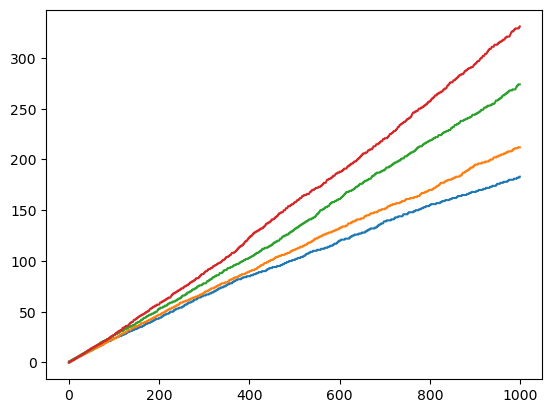

In [5]:
# Plot your result
import matplotlib.pyplot as plt
plt.plot(np.arange(len(arm_counts_history)), arm_counts_history)
plt.show()

### Question 2

Compare UCB, Epsilon-greedy and a random policy. Simulate each strategy with 5 runs for 100, 1000, 10000 and 100000 steps.

Running for 100 steps
Running for 1000 steps
Running for 10000 steps
Running for 100000 steps


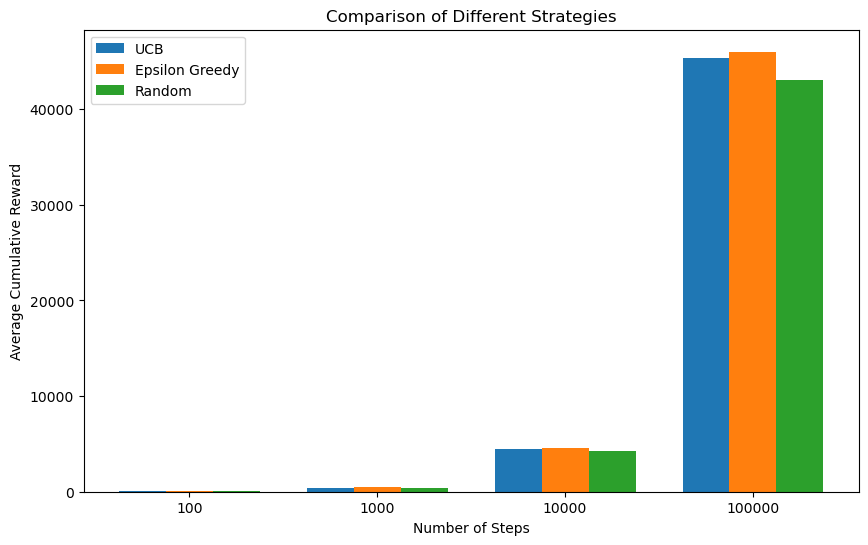


Results for 100 steps:
UCB: 43.11
EpsilonGreedy: 45.37
Random: 42.74

Results for 1000 steps:
UCB: 433.89
EpsilonGreedy: 457.03
Random: 429.34

Results for 10000 steps:
UCB: 4416.00
EpsilonGreedy: 4519.08
Random: 4305.62

Results for 100000 steps:
UCB: 45306.10
EpsilonGreedy: 45997.40
Random: 43014.19


In [6]:
# your code
def compare_strategies(num_steps_list, num_runs=5):
    results = {steps: {'UCB': 0, 'EpsilonGreedy': 0, 'Random': 0} for steps in num_steps_list}

    for steps in num_steps_list:
        print(f"Running for {steps} steps")

        for _ in range(num_runs):
            # UCB
            bandit = KArmedBandit(number_of_arms, true_rewards, width)
            ucb = Ucb(number_of_arms)

            for i in range(steps):
                j = ucb.choose_arm()
                reward = bandit.pull_arm(j)
                ucb.update(reward, j)

            results[steps]['UCB'] += bandit.get_cummulative_reward() / num_runs

            # Epsilon-greedy
            bandit = KArmedBandit(number_of_arms, true_rewards, width)
            epsilon = 0.1
            eps = EpsilonGreedy(number_of_arms, epsilon)

            for i in range(steps):
                j = eps.choose_arm()
                reward = bandit.pull_arm(j)
                eps.update(reward, j)

            results[steps]['EpsilonGreedy'] += bandit.get_cummulative_reward() / num_runs

            # Random
            bandit = KArmedBandit(number_of_arms, true_rewards, width)

            for i in range(steps):
                reward = bandit.pull_arm(np.random.choice(number_of_arms))

            results[steps]['Random'] += bandit.get_cummulative_reward() / num_runs

    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(num_steps_list))
    bar_width = 0.25  # Renamed to avoid conflict with global 'width'

    ucb_rewards = [results[steps]['UCB'] for steps in num_steps_list]
    eps_rewards = [results[steps]['EpsilonGreedy'] for steps in num_steps_list]
    random_rewards = [results[steps]['Random'] for steps in num_steps_list]

    ax.bar(x - bar_width, ucb_rewards, bar_width, label='UCB')
    ax.bar(x, eps_rewards, bar_width, label='Epsilon Greedy')
    ax.bar(x + bar_width, random_rewards, bar_width, label='Random')

    ax.set_xticks(x)
    ax.set_xticklabels([str(steps) for steps in num_steps_list])
    ax.set_xlabel('Number of Steps')
    ax.set_ylabel('Average Cumulative Reward')
    ax.set_title('Comparison of Different Strategies')
    ax.legend()

    plt.show()

    return results

# Run comparison
num_steps_list = [100, 1_000, 10_000, 100_000]
results = compare_strategies(num_steps_list)

# Print results
for steps in num_steps_list:
    print(f"\nResults for {steps} steps:")
    for strategy, reward in results[steps].items():
        print(f"{strategy}: {reward:.2f}")

> **Answer:** We hereby compare 3 strategies for solving the multi-armed bandit problem:
> - **Upper Confidence Bound (UCB)** - Balances exploration/exploitation using confidence intervals
> - **Epsilon-Greedy** - Exploits the best known arm with probability ($1-\varepsilon$) and explores random arms with probability $\varepsilon$
> - **Random** - Selects arms randomly (this strategy serves as a baseline)
>
> The results show that:
> - For all step counts, Epsilon-Greedy performs best
> - UCB consistently outperforms Random
> - The performance gap between intelligent strategies (UCB, Epsilon-Greedy) and Random increases with more steps, even though the Random strategy performs better than I expected
> - Epsilon-Greedy's advantage comes from its adaptive exploration-exploitation balance with a decaying exploration rate

## Part 2: Advanced Q-learning

1. Provide classic DQN for an atari problem
2. Fix the problem of moving target with a second network
3. Fix the iid problem using a replay buffer
4. Fix the Q overtimation by distinguishing action selection and evaluation

### Approximate Q-Learning

Approximate Q-learning extends traditional Q-learning to handle environments with large state-action spaces by using function approximators, such as neural networks, to estimate the Q-function. This approach is essential when dealing with complex environments where maintaining a lookup table for all state-action pairs is impractical.

### Algorithm

1. **Initialize** $\theta$ randomly.
2. **Reset** environment to $s_0$.

3. **For** $k = 1$ to $K$, do:
   - **Select** $a_{k-1} = \arg\max_{a \in \mathcal{A}} Q_{\theta_{k-1}}(s_{k-1}, a)$ with a probability (1-$\epsilon$) and a random action with probability $\epsilon$.
   - **Take** action $a_{k-1}$ and **observe** $r_{k-1}$ and $s_{k}$.
   - **Let** $(s, a, r, s') = (s_{k-1}, a_{k-1}, r_{k-1}, s_k)$.
   - **Compute** $\delta_k = r + \gamma \max_{a' \in \mathcal{A}} Q_{\theta_{k-1}}(s', a') - Q_{\theta_{k-1}}(s, a)$.
   - **Update** $\theta_{k} = \theta_{k-1} + \alpha_k \delta_k \nabla_{\theta} Q_{\theta_{k-1}}(s, a)$.

 ## Question 1
 Complete the following code of the DQN algorithm in pytorch.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma

        self.q_network = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def act(self, state, inference=False, epsilon=0.1):
        if inference:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state)
            return q_values.argmax().item()
        else:
            if random.random() < epsilon:
                return random.choice(range(self.action_size))
            else:
                state = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = self.q_network(state)
                return q_values.argmax().item()

    def learn(self, state, action, reward, next_state, teminated):
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        reward = torch.FloatTensor([reward])
        teminated = torch.FloatTensor([teminated])

        # Compute the target Q value
        with torch.no_grad():
            max_next_q_value = self.q_network(next_state).max(1)[0]
            target_q_value = reward + (1 - teminated) * self.gamma * max_next_q_value

        # Get the current Q value
        current_q_value = self.q_network(state).gather(1, torch.LongTensor([[action]])).squeeze()

        # Compute the loss
        loss = nn.MSELoss()(current_q_value, target_q_value)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [8]:
# Test your code

import gymnasium as gym
from tqdm import tqdm

def test_agent(agent, env, episodes=100):
    total_reward = 0
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.act(state, inference=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = next_state
    return total_reward / episodes

def train_agent(agent, env, episodes=250, max_steps=200):
    for episode in tqdm(range(episodes)):
        state, _ = env.reset()
        done = False
        for _ in range(max_steps):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            if done:
                break

env = gym.make('CartPole-v1', render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Test before training
print("Testing before training:")
mean_reward_before = test_agent(agent, env)
print(f"Mean Reward before training: {mean_reward_before}")

# Train the agent
train_agent(agent, env, episodes=300)

# Test after training
print("Testing after training:")
mean_reward_after = test_agent(agent, env)
print(f"Mean Reward after training: {mean_reward_after}")

env.close()

Testing before training:
Mean Reward before training: 9.77


  0%|          | 0/300 [00:00<?, ?it/s]c:\Users\marti\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 300/300 [00:19<00:00, 15.51it/s]


Testing after training:
Mean Reward after training: 68.73


### Question 2. Non-Stationarity (Moving Target Problem)

Problem: The target Q-values in approximate Q-learning are constantly changing as the Q-function is updated, leading to a non-stationary target. This makes the learning process unstable and can cause divergence.

Solution: Use a target network that is updated less frequently than the main Q-network. This provides a fixed target for a period, stabilizing the learning process.

### Algorithm

1. **Initialize** $\theta$ randomly.
2. **Copy** $\theta$ to $\theta^{\prime}$ (target network).
3. **Reset** environment to $s_0$.

4. **For** $k = 1$ to $K$, do:
   - **Select** $a_{k-1} = \arg\max_{a \in \mathcal{A}} Q_{\theta_{k-1}}(s_{k-1}, a)$ with a probability (1-$\epsilon$) and a random action with probability $\epsilon$.
   - **Take** action $a_{k-1}$ and **observe** $r_{k-1}$ and $s_{k}$.
   - **Let** $(s, a, r, s') = (s_{k-1}, a_{k-1}, r_{k-1}, s_k)$.
   - **Compute** $\delta_k = r + \gamma \max_{a' \in \mathcal{A}} Q_{\theta^{\prime}}(s', a') - Q_{\theta_{k-1}}(s, a)$.
   - **Update** $\theta_{k} = \theta_{k-1} + \alpha_k \delta_k \nabla_{\theta} Q_{\theta_{k-1}}(s, a)$.
   - **Periodically update**  $\theta^{\prime}$ with the $\theta_k$ .

Update the Approximate Q-learning algorithm using a using target network. Start from the previous implementation.

In [9]:
# Question 2: Moving Target Problem Solution - DQN with Target Network

class DQNAgentWithTarget:
    def __init__(self, state_size, action_size, gamma=0.99, lr=0.001, target_update_freq=10):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.target_update_freq = target_update_freq
        self.update_counter = 0

        # Main network for action selection
        self.q_network = QNetwork(state_size, action_size)

        # Target network for stable learning targets
        self.target_network = QNetwork(state_size, action_size)

        # Initialize target network with same weights as q_network
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()  # Set to evaluation mode

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def act(self, state, inference=False, epsilon=0.1):
        if inference:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state)
            return q_values.argmax().item()
        else:
            if random.random() < epsilon:
                return random.choice(range(self.action_size))
            else:
                state = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = self.q_network(state)
                return q_values.argmax().item()

    def learn(self, state, action, reward, next_state, terminated):
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        reward = torch.FloatTensor([reward])
        terminated = torch.FloatTensor([terminated])

        # Compute the target Q value using target network
        with torch.no_grad():
            max_next_q_value = self.target_network(next_state).max(1)[0]
            target_q_value = reward + (1 - terminated) * self.gamma * max_next_q_value

        # Get the current Q value
        current_q_value = self.q_network(state).gather(1, torch.LongTensor([[action]])).squeeze()

        # Compute the loss
        loss = nn.MSELoss()(current_q_value, target_q_value)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network periodically
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

# Test the agent with target network
def test_target_network():
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Create agent with target network
    agent = DQNAgentWithTarget(state_size, action_size, target_update_freq=10)

    # Test before training
    print("Testing agent with target network before training:")
    mean_reward_before = test_agent(agent, env)
    print(f"Mean Reward before training: {mean_reward_before}")

    # Train the agent
    train_agent(agent, env, episodes=300)

    # Test after training
    print("Testing agent with target network after training:")
    mean_reward_after = test_agent(agent, env)
    print(f"Mean Reward after training: {mean_reward_after}")

    env.close()
    return mean_reward_before, mean_reward_after

### Question 3. Non IID samples (correlated samples).

Problem: The agent's experiences are sequentially correlated because they are collected from consecutive time steps in the environment. This violates the assumption of independent and identically distributed (IID) samples, which is a common requirement for many machine learning algorithms, including those used to train neural networks. The lack of IID samples can lead to inefficient learning and instability in the training process.

Solution: Use a technique called experience replay. Experience replay involves storing the agent's experiences in a replay buffer and sampling random mini-batches of experiences from this buffer to update the Q-network. This approach helps to break the correlation between consecutive experiences and provides a more diverse set of training samples, which can lead to more stable and efficient learning.

### Algorithm

1. **Initialize** $\theta$ randomly.
2. **Initialize** empty buffer $\mathcal{B}$
3. **Reset** environment to $s_0$.

3. **For** $k = 1$ to $K$, do:
   - **Select** $a_{k-1} = \arg\max_{a \in \mathcal{A}} Q_{\theta_{k-1}}(s_{k-1}, a)$ with a probability (1-$\epsilon$) and a random action with probability $\epsilon$.
   - **Take** action $a_{k-1}$ and **observe** $r_{k-1}$ and $s_{k}$.
   - **Store** transition $(s_{k-1}, a_{k-1}, r_{k-1}, s_k)$ in $\mathcal{B}$.
   - **Sample** transition $(s, a, r, s')$ from $\mathcal{B}$.
   - **Compute** $\delta_k = r + \gamma \max_{a' \in \mathcal{A}} Q_{\theta_{k-1}}(s', a') - Q_{\theta_{k-1}}(s, a)$.
   - **Update** $\theta_{k} = \theta_{k-1} + \alpha_k \delta_k \nabla_{\theta} Q_{\theta_{k-1}}(s, a)$.

Implement the approximate Q-learning algorithm with a replay buffer.

In [10]:
# Question 3: Experience Replay Buffer Implementation

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

class DQNAgentWithReplay:
    def __init__(self, state_size, action_size, gamma=0.99, lr=0.001,
                 buffer_size=10000, batch_size=64, target_update_freq=10):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.update_counter = 0

        # Networks
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size)

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def act(self, state, inference=False, epsilon=0.1):
        if inference:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state)
            return q_values.argmax().item()
        else:
            if random.random() < epsilon:
                return random.choice(range(self.action_size))
            else:
                state = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = self.q_network(state)
                return q_values.argmax().item()

    def store(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def learn(self, state=None, action=None, reward=None, next_state=None, terminated=None):
        # Store experience if provided
        if state is not None:
            self.store(state, action, reward, next_state, terminated)

        # If not enough samples in memory, skip update
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Get current Q values
        current_q_values = self.q_network(states).gather(1, actions).squeeze(1)

        # Compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network periodically
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

# Test the agent with replay buffer
def test_replay_buffer():
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Create agent with replay buffer
    agent = DQNAgentWithReplay(state_size, action_size, buffer_size=10000, batch_size=64)

    # Training function for agent with replay buffer
    def train_agent_with_replay(agent, env, episodes=250, max_steps=200):
        for episode in tqdm(range(episodes)):
            state, _ = env.reset()
            done = False
            for _ in range(max_steps):
                action = agent.act(state, epsilon=max(0.1, 1.0 - episode/200))  # Decay epsilon
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                agent.store(state, action, reward, next_state, done)
                agent.learn()
                state = next_state
                if done:
                    break

    # Test before training
    print("Testing agent with replay buffer before training:")
    mean_reward_before = test_agent(agent, env)
    print(f"Mean Reward before training: {mean_reward_before}")

    # Train the agent
    train_agent_with_replay(agent, env, episodes=300)

    # Test after training
    print("Testing agent with replay buffer after training:")
    mean_reward_after = test_agent(agent, env)
    print(f"Mean Reward after training: {mean_reward_after}")

    env.close()
    return mean_reward_before, mean_reward_after

### Question 4: Q-value Overestimation (overestimation of maximum sampling)

Problem : The max operator used in the update rule can lead to overestimation of action values. This happens because the same Q-values are used both to select and evaluate actions, which can introduce a bias. This overestimation can degrade the performance of the learning algorithm.

Solution: Double Q-learning addresses the overestimation problem by decoupling the action selection from the action evaluation. This is achieved by maintaining two separate Q-value estimates and using one set of estimates to determine the best action and the other to evaluate that action. This approach reduces the bias introduced by the max operator.

### Algorithm

1. **Initialize** $\theta$ randomly.
2. **Copy** $\theta$ to $\theta^{\prime}$ (target network).
3. **Reset** environment to $s_0$.

4. **For** $k = 1$ to $K$, do:
   - **Select** $a_{k-1} = \arg\max_{a \in \mathcal{A}} Q_{\theta_{k-1}}(s_{k-1}, a)$ with a probability (1-$\epsilon$) and a random action with probability $\epsilon$.
   - **Take** action $a_{k-1}$ and **observe** $r_{k-1}$ and $s_{k}$.
   - **Let** $(s, a, r, s') = (s_{k-1}, a_{k-1}, r_{k-1}, s_k)$.
   - **Compute** $\delta_k = r + \gamma \max_{a' \in \mathcal{A}} Q_{\theta_{k-1}}(s', \argmax_{a' \in \mathcal{A}} Q_{\theta^{\prime}_(s', a')}) - Q_{\theta_{k-1}}(s, a)$.
   - **Update** $\theta_{k} = \theta_{k-1} + \alpha_k \delta_k \nabla_{\theta} Q_{\theta_{k-1}}(s, a)$.
   - **Periodically update**  $\theta^{\prime}$ with the $\theta_k$.

Implement the approximate Q-learning algorithm with a double Q.


Testing all DQN implementations:

1. Basic DQN


100%|██████████| 300/300 [00:23<00:00, 12.73it/s]


Basic DQN final reward: 78.11

2. DQN with Target Network
Testing agent with target network before training:
Mean Reward before training: 9.44


100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


Testing agent with target network after training:
Mean Reward after training: 20.98
Target DQN final reward: 20.98

3. DQN with Replay Buffer
Testing agent with replay buffer before training:
Mean Reward before training: 9.28


100%|██████████| 300/300 [02:52<00:00,  1.74it/s]


Testing agent with replay buffer after training:
Mean Reward after training: 463.78
Replay DQN final reward: 463.78

4. Double DQN
Testing Double DQN agent before training:
Mean Reward before training: 9.33


100%|██████████| 300/300 [01:33<00:00,  3.22it/s]


Testing Double DQN agent after training:
Mean Reward after training: 116.47
Double DQN final reward: 116.47



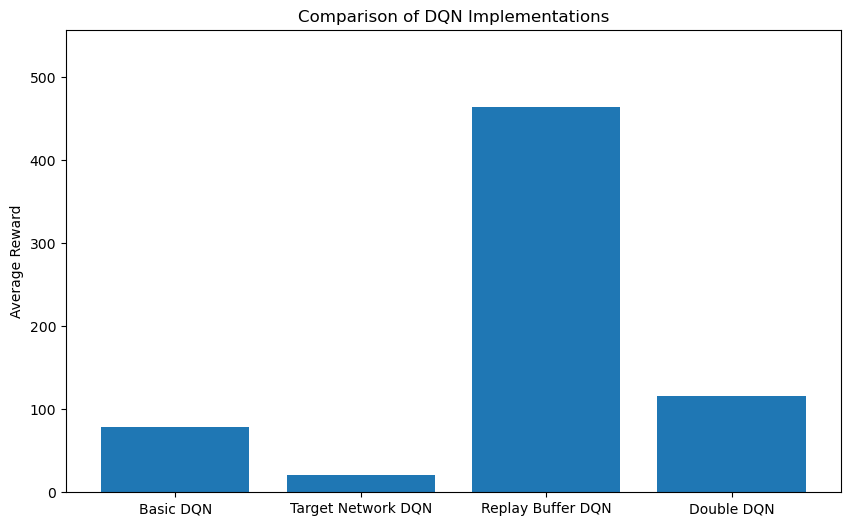

In [11]:
# Question 4: Double DQN Implementation (Addressing Q-value Overestimation)

class DoubleDQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, lr=0.001,
                 buffer_size=10000, batch_size=64, target_update_freq=10):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.update_counter = 0

        # Networks
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size)

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def act(self, state, inference=False, epsilon=0.1):
        if inference:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state)
            return q_values.argmax().item()
        else:
            if random.random() < epsilon:
                return random.choice(range(self.action_size))
            else:
                state = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = self.q_network(state)
                return q_values.argmax().item()

    def store(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def learn(self, state=None, action=None, reward=None, next_state=None, terminated=None):
        # Store experience if provided
        if state is not None:
            self.store(state, action, reward, next_state, terminated)

        # If not enough samples in memory, skip update
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Double DQN: Use online network to SELECT actions and target network to EVALUATE actions
        with torch.no_grad():
            # Get actions from online network (selection)
            next_actions = self.q_network(next_states).argmax(1, keepdim=True)

            # Evaluate those actions using target network
            next_q_values = self.target_network(next_states).gather(1, next_actions).squeeze(1)

            # Compute target values
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Get current Q values
        current_q_values = self.q_network(states).gather(1, actions).squeeze(1)

        # Compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network periodically
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

# Test the Double DQN agent
def test_double_dqn():
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Create Double DQN agent
    agent = DoubleDQNAgent(state_size, action_size, buffer_size=10000, batch_size=64)

    # Training function for Double DQN agent
    def train_double_dqn_agent(agent, env, episodes=250, max_steps=200):
        for episode in tqdm(range(episodes)):
            state, _ = env.reset()
            done = False
            for _ in range(max_steps):
                action = agent.act(state, epsilon=max(0.1, 1.0 - episode/200))  # Decay epsilon
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                agent.store(state, action, reward, next_state, done)
                agent.learn()
                state = next_state
                if done:
                    break

    # Test before training
    print("Testing Double DQN agent before training:")
    mean_reward_before = test_agent(agent, env)
    print(f"Mean Reward before training: {mean_reward_before}")

    # Train the agent
    train_double_dqn_agent(agent, env, episodes=300)

    # Test after training
    print("Testing Double DQN agent after training:")
    mean_reward_after = test_agent(agent, env)
    print(f"Mean Reward after training: {mean_reward_after}")

    env.close()
    return mean_reward_before, mean_reward_after

# Run all the implementations and compare results
print("\nTesting all DQN implementations:\n")

print("1. Basic DQN")
env = gym.make('CartPole-v1', render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
train_agent(agent, env, episodes=300)
basic_dqn_reward = test_agent(agent, env)
print(f"Basic DQN final reward: {basic_dqn_reward}\n")
env.close()

print("2. DQN with Target Network")
target_dqn_before, target_dqn_after = test_target_network()
print(f"Target DQN final reward: {target_dqn_after}\n")

print("3. DQN with Replay Buffer")
replay_dqn_before, replay_dqn_after = test_replay_buffer()
print(f"Replay DQN final reward: {replay_dqn_after}\n")

print("4. Double DQN")
double_dqn_before, double_dqn_after = test_double_dqn()
print(f"Double DQN final reward: {double_dqn_after}\n")

# Compare all methods
methods = ['Basic DQN', 'Target Network DQN', 'Replay Buffer DQN', 'Double DQN']
rewards = [basic_dqn_reward, target_dqn_after, replay_dqn_after, double_dqn_after]

plt.figure(figsize=(10, 6))
plt.bar(methods, rewards)
plt.ylabel('Average Reward')
plt.title('Comparison of DQN Implementations')
plt.ylim(0, max(rewards) * 1.2)
plt.show()



> **Analysis:** The tests of the different DQN policies reveal significant variations in performance.  
> - The **Basic DQN** implementation serves as a baseline, achieving a final reward of $78.11$. 
> - In contrast, the **DQN with Target Network** shows notably lower performance, with a final reward of $20.98$, which was unexpected. The purpose of using a target network should be to stabilize learning, but in this case, it appears to have had a negative impact. This might indicate issues related to the update frequency or my implementation of the network.  
> - The **DQN with Replay Buffer** is the best network by far, achieving a final reward of $463.78$. This significant boost in performance can potentially be attributed to the ability of the replay buffer to break correlations in the training data and enable the agent to learn more efficiently by reusing past experiences.
> - Finally, the **Double DQN** implementation achieves a final reward of $116.47$, which, while better than the basic version, is still far from the results obtained with the replay buffer. Double DQN is in fact designed to reduce overestimation bias, and the small improvement it brings shows its ability to balance value estimation but in this case, without drastically enhancing overall performance, which is surprising.
>
> In conclusion, the most substantial impact on performance is observed with the replay buffer, while the target network surprisingly shows limited effectiveness. Double DQN, on the other hand, provides a small improvement over the basic DQN.